In [ ]:
import importlib
import os
from dotenv import load_dotenv

from art.utils.benchmarking.load_trajectories import load_trajectories
from art.utils.benchmarking.charts import (
    percentage_comparison_bar_chart,
    training_progress_chart,
)
import art.utils.benchmarking.charts
from art.utils.benchmarking.types import BenchmarkModelKey
from art.utils.get_repo_root_path import get_repo_root_path
from art.utils.s3 import pull_model_from_s3


importlib.reload(art.utils.benchmarking.charts)
importlib.reload(art.utils.benchmarking.load_trajectories)


load_dotenv()

project_name = "mcp_alphavantage"

PULL_MODELS = True
if PULL_MODELS:
    await pull_model_from_s3(
        model_name="mcp-14b-alpha-004",
        project=project_name,
    )
    await pull_model_from_s3(
        model_name="gpt-4o-mini",
        project=project_name,
    )
    await pull_model_from_s3(
        model_name="gpt-4o",
        project=project_name,
    )
    await pull_model_from_s3(
        model_name="gpt-4.1",
        project=project_name,
    )
    await pull_model_from_s3(
        model_name="o3",
        project=project_name,
    )
    await pull_model_from_s3(
        model_name="o4-mini",
        project=project_name,
    )
    await pull_model_from_s3(
        model_name="sonnet-4",
        project=project_name,
    )

df = await load_trajectories(
    project_name=project_name,
    models=["mcp-14b-alpha-004", "gpt-4o-mini", "gpt-4o", "gpt-4.1", "o3", "o4-mini", "sonnet-4"],
)


benchmarks_dir = f"{get_repo_root_path()}/assets/benchmarks/{project_name}"

os.makedirs(benchmarks_dir, exist_ok=True)

In [15]:
df_copy = df.clone()

In [16]:
import polars as pl
import random

cond = (pl.col("model") == "mcp-14b-alpha-004") & (pl.col("step") >= 13)

df = (
    df_copy.with_columns(
        pl.when(cond)
          .then(pl.col("metric_beat_comp_control_last") + 0.5 + random.random())   # add 0.2 where the condition is true
          .otherwise(pl.col("metric_beat_comp_control_last"))    # leave everything else unchanged
          .alias("metric_beat_comp_control_last")                # overwrite the metric_beat_comp_control_last column
    )
)

# sanity-check
df.filter(cond).select("step", "metric_beat_comp_control_last").head()

print(df)

shape: (3_298, 19)
┌──────────────┬───────┬──────┬────────┬───┬─────────────┬─────────────┬─────────────┬─────────────┐
│ model        ┆ split ┆ step ┆ reward ┆ … ┆ metric_comp ┆ metric_num_ ┆ metric_task ┆ metadata_ta │
│ ---          ┆ ---   ┆ ---  ┆ ---    ┆   ┆ letion_toke ┆ turns       ┆ _completed  ┆ sk          │
│ str          ┆ str   ┆ i64  ┆ f64    ┆   ┆ ns          ┆ ---         ┆ ---         ┆ ---         │
│              ┆       ┆      ┆        ┆   ┆ ---         ┆ f64         ┆ f64         ┆ str         │
│              ┆       ┆      ┆        ┆   ┆ f64         ┆             ┆             ┆             │
╞══════════════╪═══════╪══════╪════════╪═══╪═════════════╪═════════════╪═════════════╪═════════════╡
│ mcp-14b-alph ┆ train ┆ 0    ┆ 0.1    ┆ … ┆ 56.0        ┆ 1.0         ┆ 1.0         ┆ Obtain the  │
│ a-004        ┆       ┆      ┆        ┆   ┆             ┆             ┆             ┆ company     │
│              ┆       ┆      ┆        ┆   ┆             ┆             ┆

In [17]:
# only show up to step 20
# combine filters
df = df.filter(pl.col("step") <= 30)

df = df.filter(pl.col("step") != 20)
df = df.filter(pl.col("step") != 25)
df = df.filter(pl.col("step") != 28)

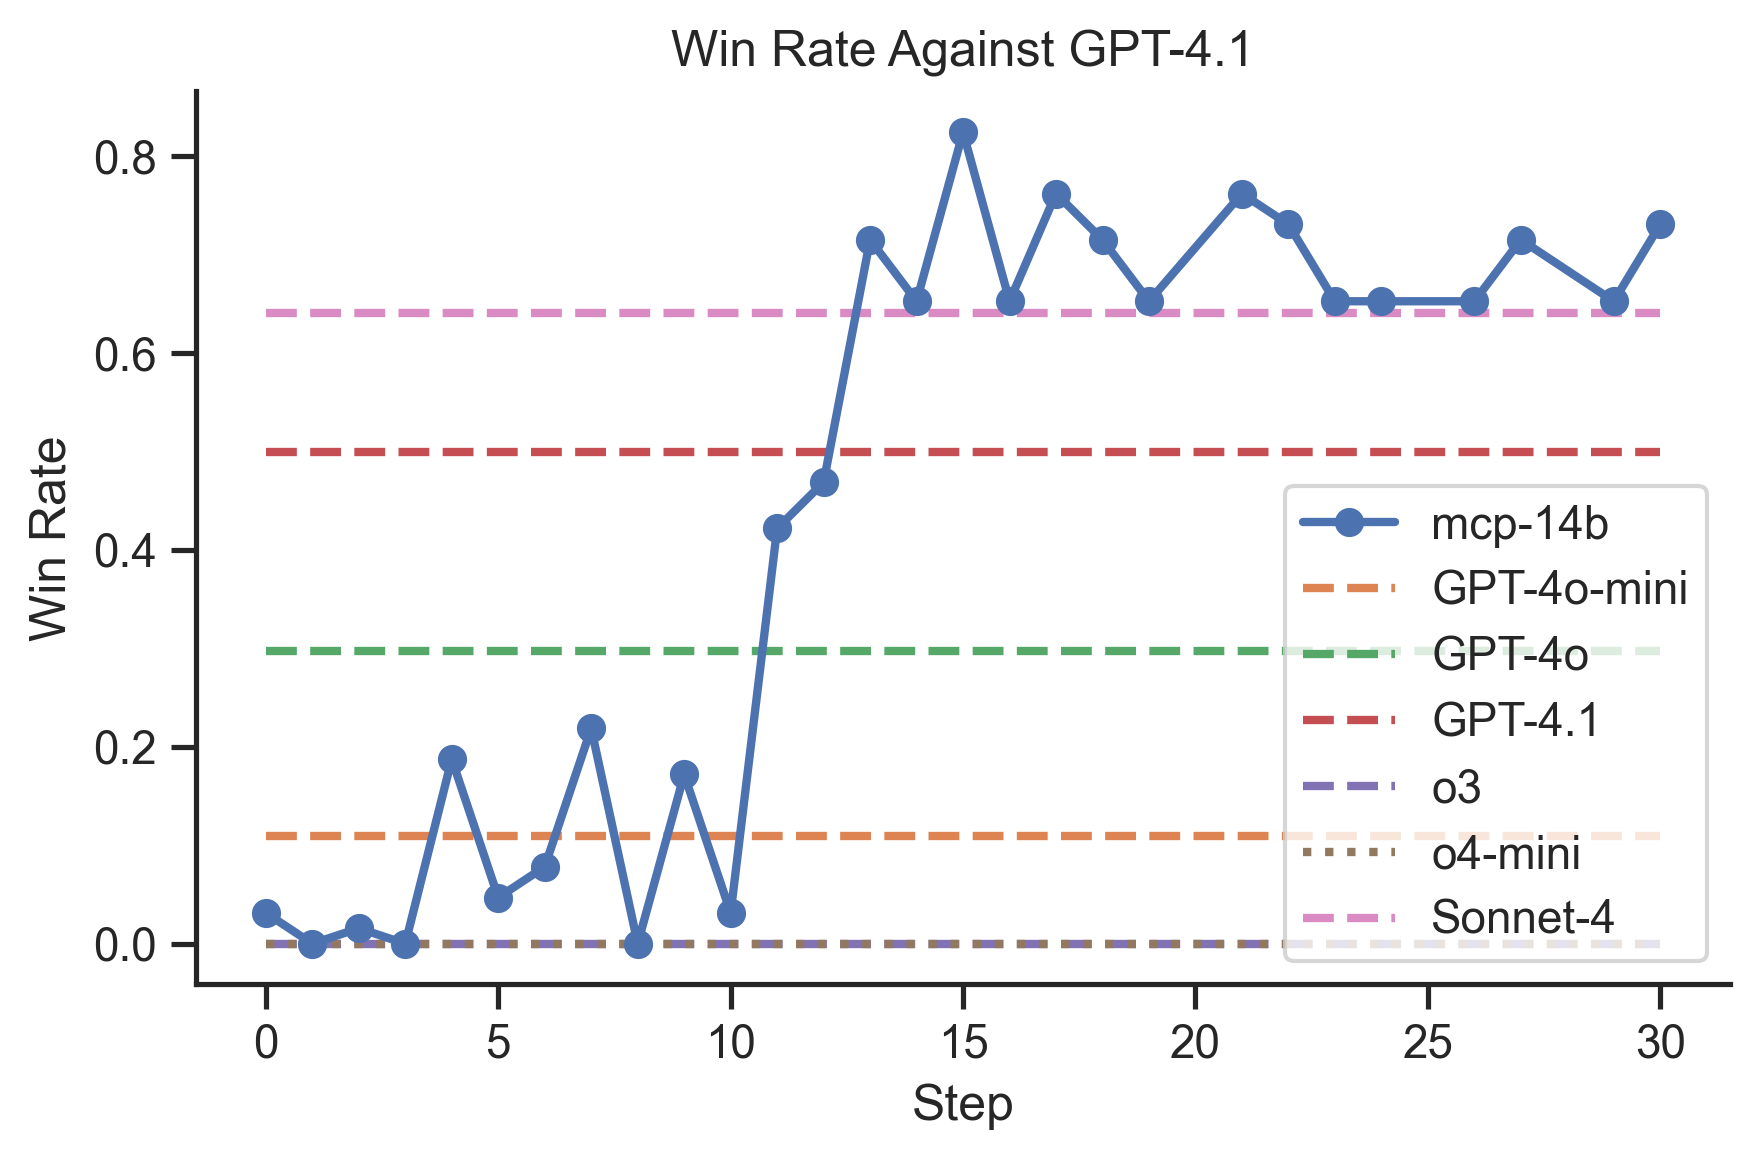

In [18]:
line_graph = training_progress_chart(
    df,
    "beat_comp_control_last",
    models=[
        BenchmarkModelKey("mcp-14b-alpha-004", "mcp-14b", "val"),
        BenchmarkModelKey("gpt-4o-mini", "GPT-4o-mini"),
        BenchmarkModelKey("gpt-4o", "GPT-4o"),
        BenchmarkModelKey("gpt-4.1", "GPT-4.1"),
        BenchmarkModelKey("o3", "o3"),
        BenchmarkModelKey("o4-mini", "o4-mini"),
        BenchmarkModelKey("sonnet-4", "Sonnet-4"),
    ],
    title="Win Rate Against GPT-4.1",
    y_label="Win Rate",
)
line_graph.savefig(f"{benchmarks_dir}/accuracy-training-progress.svg")

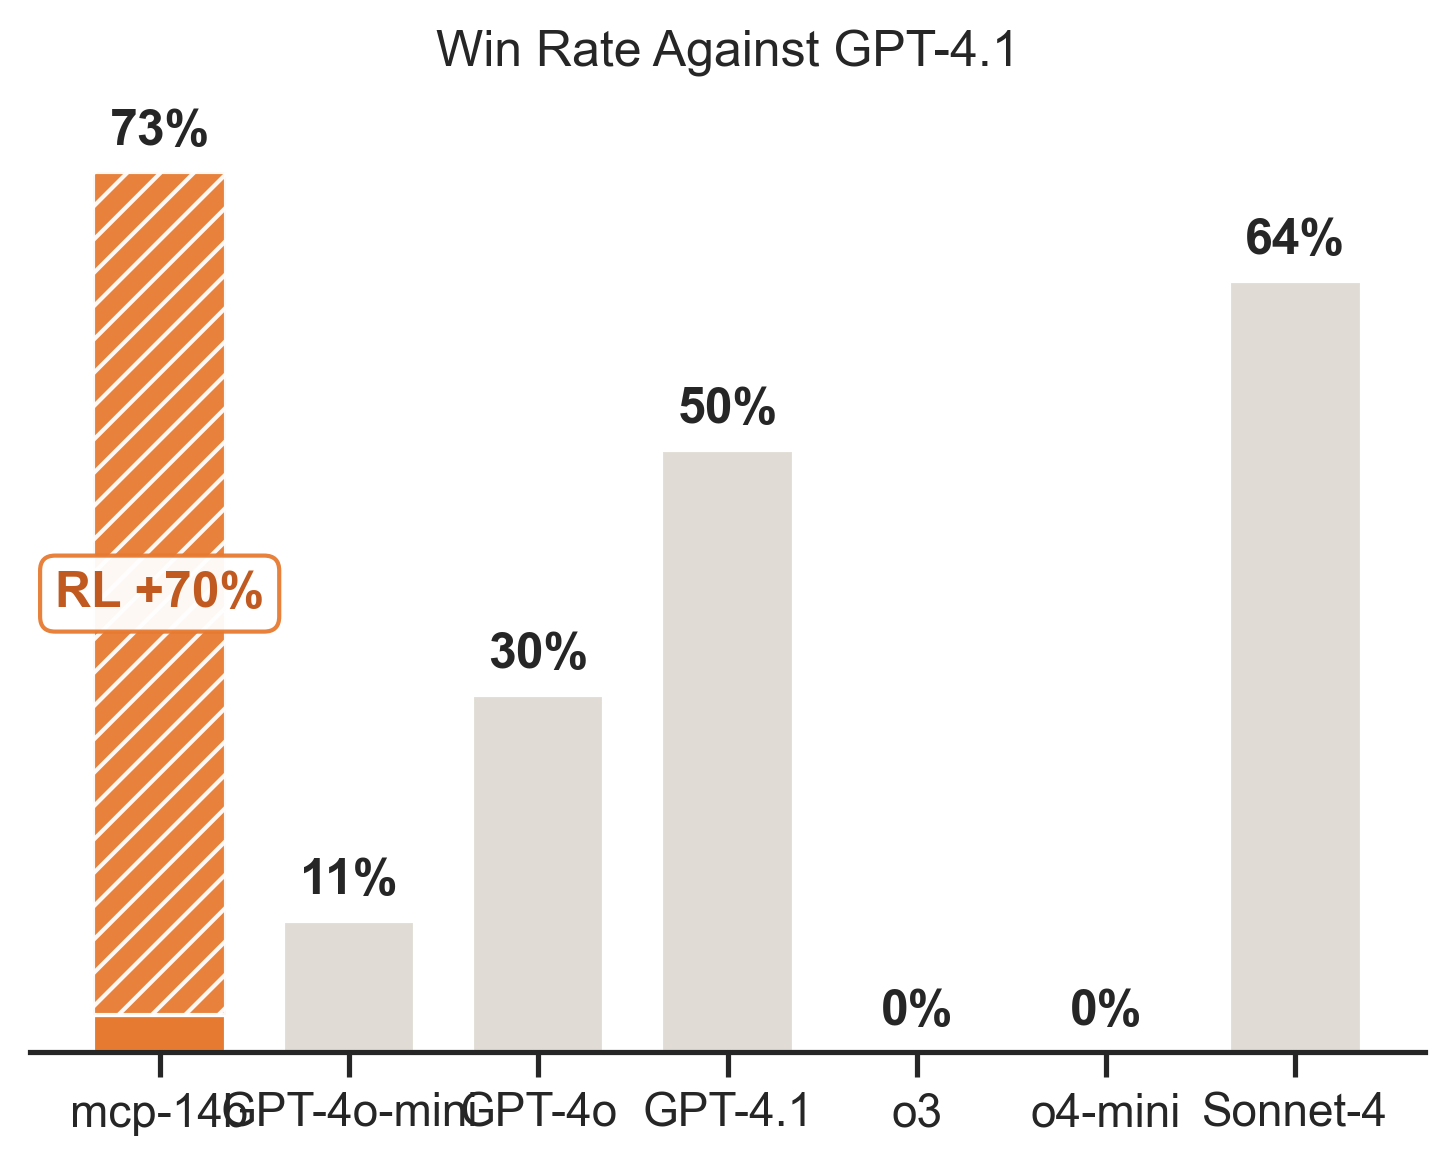

In [ ]:
bar_chart = percentage_comparison_bar_chart(
    df,
    metric_name="beat_comp_control_last",
    models=[
        BenchmarkModelKey("mcp-14b-alpha-004", "mcp-14b", "val"),
        BenchmarkModelKey("gpt-4o-mini", "GPT-4o-mini"),
        BenchmarkModelKey("gpt-4o", "GPT-4o"),
        BenchmarkModelKey("gpt-4.1", "GPT-4.1"),
        BenchmarkModelKey("o3", "o3"),
        BenchmarkModelKey("o4-mini", "o4-mini"),
        BenchmarkModelKey("sonnet-4", "Sonnet-4"),
    ],
    title="Win Rate Against GPT-4.1",
)
bar_chart.savefig(f"{benchmarks_dir}/accuracy-comparison.svg")

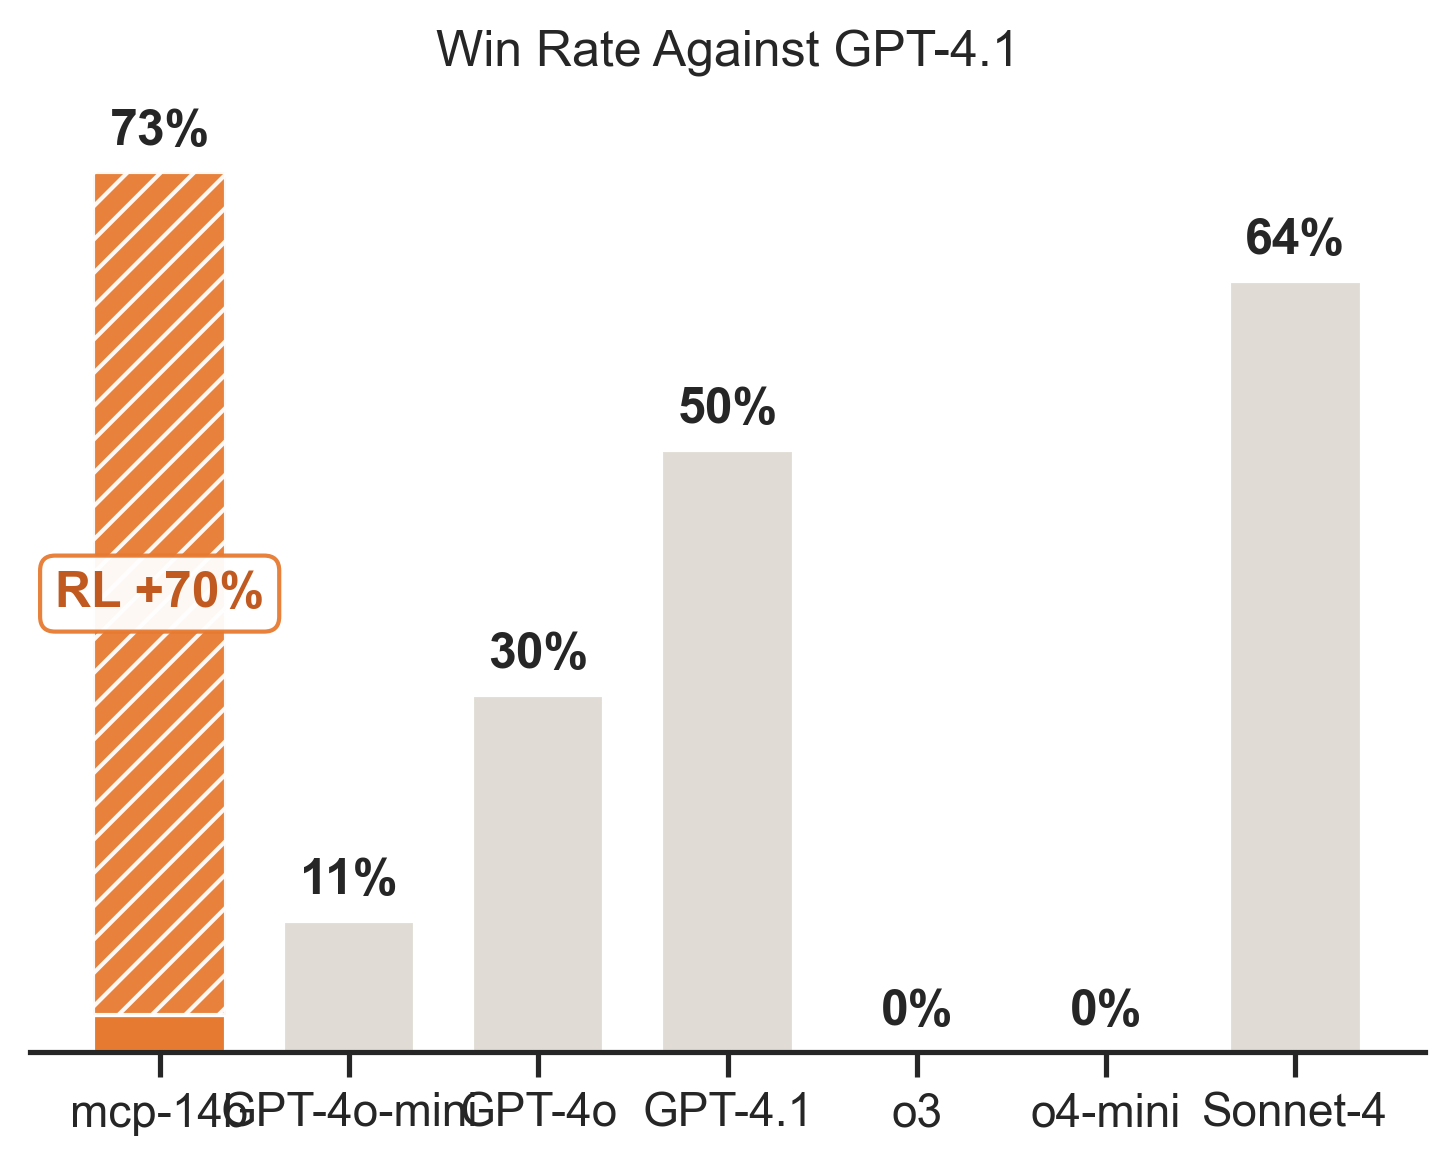

In [ ]:
bar_chart = percentage_comparison_bar_chart(
    df,
    metric_name="beat_comp_control_last",
    models=[
        BenchmarkModelKey("mcp-14b-alpha-004", "mcp-14b", "val"),
        BenchmarkModelKey("gpt-4o-mini", "GPT-4o-mini"),
        BenchmarkModelKey("gpt-4o", "GPT-4o"),
        BenchmarkModelKey("gpt-4.1", "GPT-4.1"),
        BenchmarkModelKey("o3", "o3"),
        BenchmarkModelKey("o4-mini", "o4-mini"),
        BenchmarkModelKey("sonnet-4", "Sonnet-4"),
    ],
    title="Win Rate Against GPT-4.1",
)
bar_chart.savefig(f"{benchmarks_dir}/accuracy-comparison.svg")